# **Exercise 1: Predict whether the person will show up for his medical appointment**

---




**Understanding the data: medical appointment train.csv**


> The dataset altogether has 14 features. 13 independent features and 1 dependent which is the target feature: **No-show** with 'Yes' or 'No' values. 
>
> 5 category of patients: Conditions with '0' or '1' values
>
> *  Scholarship
> *  Hypertension
> *   Diabetes
> *   Alcoholism
> *   Handicap







## Import

> *   All necessary libraries for the task
> *   Data from drive



In [1]:
import os
import tensorflow

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.metrics import f1_score, confusion_matrix ,accuracy_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score

from keras.models import Model, Sequential
from keras.optimizers import Adadelta, RMSprop, SGD, Adam
from keras.layers import Input, Dense, Flatten, Dropout
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


> Mount the google drive(for colab)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


> Import the dataset and extract information from the csv file

In [3]:
data= pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/medical_appointment_train.csv')
#data.describe
data.head(10)

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
5,9.598513e+13,5626772,F,2016-04-27T08:36:51Z,2016-04-29T00:00:00Z,76,REPÚBLICA,0,1,0,0,0,0,No
6,7.336882e+14,5630279,F,2016-04-27T15:05:12Z,2016-04-29T00:00:00Z,23,GOIABEIRAS,0,0,0,0,0,0,Yes
7,3.449833e+12,5630575,F,2016-04-27T15:39:58Z,2016-04-29T00:00:00Z,39,GOIABEIRAS,0,0,0,0,0,0,Yes
8,5.639473e+13,5638447,F,2016-04-29T08:02:16Z,2016-04-29T00:00:00Z,21,ANDORINHAS,0,0,0,0,0,0,No
9,7.812456e+13,5629123,F,2016-04-27T12:48:25Z,2016-04-29T00:00:00Z,19,CONQUISTA,0,0,0,0,0,0,No


In [4]:
data.info()
print ("Rows: ", data.shape[0])
print ("Columns: ", data.shape[1])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientID         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hypertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handicap          110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB
Rows:  110527
Columns:  14


In [5]:
data.nunique()

PatientID          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hypertension           2
Diabetes               2
Alcoholism             2
Handicap               5
SMS_received           2
No-show                2
dtype: int64

## Processing of data



>  *   With and without preprocessing of data
>  *   Implement 10-fold crossvalidation to avoid overfitting






**With data preprocessing** : 

> Analyze the dataset. Key observations: 
>
> *   PatientID is float : Cast it to int64
> *   Check for invalid entries
> *   Check the dependencies of features: Drop unrealated features
> *    Check for duplicates - no duplicate values in dataset
> *    Negative age present. -1. Cap the age from 0-100





In [6]:
dupl= sum(data.duplicated())
print(dupl) #check for duplicates. Sum has to be 0.

data.isnull().any() #null entry check

data['PatientID'] = data['PatientID'].astype(int)

#map Gender and No-show to 0 and 1 to make it plottable
data['Gender'] = data['Gender'].map({'M':1, 'F':0})
data['No-show'] = data['No-show'].map({'Yes':1, 'No':0})

#convert Appointment day and Schedule day to datetime
# data['ScheduledDay'] = data['ScheduledDay'].apply(np.datetime64)
# data['AppointmentDay']   = data['AppointmentDay'].apply(np.datetime64)
# data['ScheduledDay'] = data['ScheduledDay'].apply(lambda x: x.strftime("%Y-%m-%d"))
# data['AppointmentDay'] = data['AppointmentDay'].apply(lambda x: x.strftime("%Y-%m-%d"))

#format date 
# d = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
data['Modified_AppointmentDay'] = data['AppointmentDay'].map(lambda x: datetime.strptime(x,"%Y-%m-%dT%H:%M:%SZ"))
data['AppointmentDay_Month'] = data['Modified_AppointmentDay'].map(lambda x: x.month)
data['AppointmentDay_Day'] = data['Modified_AppointmentDay'].map(lambda x: x.day)
data['AppointmentDay_Weekday'] = data['Modified_AppointmentDay'].map(lambda x: x.weekday())
# data['AppointmentDay_weekday'] = data['AppointmentDay_weekday'].dt.weekday

data['Modified_ScheduledDay'] = data['ScheduledDay'].map(lambda x: datetime.strptime(x,"%Y-%m-%dT%H:%M:%SZ"))
data['ScheduledDay_Month'] = data['Modified_ScheduledDay'].map(lambda x: x.month)
data['ScheduledDay_Day'] = data['Modified_ScheduledDay'].map(lambda x: x.day)
data['ScheduledDay_Weekday'] = data['Modified_ScheduledDay'].map(lambda x: x.weekday())
# data['ScheduledDay_weekday'] = data['ScheduledDay_weekday'].replace(d)

data['Num_App_Missed'] = data.groupby('PatientID')['No-show'].apply(lambda x: x.cumsum())

print('Age: ', sorted (data.Age.unique()))
data = data[(data['Age']>=0) & (data['Age']<100)]
print('Age: ', sorted (data.Age.unique()))

data.head(10)
#data.info()

0
Age:  [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 115]
Age:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show,Modified_AppointmentDay,AppointmentDay_Month,AppointmentDay_Day,AppointmentDay_Weekday,Modified_ScheduledDay,ScheduledDay_Month,ScheduledDay_Day,ScheduledDay_Weekday,Num_App_Missed
0,29872499824296,5642903,0,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,0,2016-04-29,4,29,4,2016-04-29 18:38:08,4,29,4,0
1,558997776694438,5642503,1,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,0,2016-04-29,4,29,4,2016-04-29 16:08:27,4,29,4,0
2,4262962299951,5642549,0,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,0,2016-04-29,4,29,4,2016-04-29 16:19:04,4,29,4,0
3,867951213174,5642828,0,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,2016-04-29,4,29,4,2016-04-29 17:29:31,4,29,4,0
4,8841186448183,5642494,0,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,0,2016-04-29,4,29,4,2016-04-29 16:07:23,4,29,4,0
5,95985133231274,5626772,0,2016-04-27T08:36:51Z,2016-04-29T00:00:00Z,76,REPÚBLICA,0,1,0,0,0,0,0,2016-04-29,4,29,4,2016-04-27 08:36:51,4,27,2,0
6,733688164476661,5630279,0,2016-04-27T15:05:12Z,2016-04-29T00:00:00Z,23,GOIABEIRAS,0,0,0,0,0,0,1,2016-04-29,4,29,4,2016-04-27 15:05:12,4,27,2,1
7,3449833394123,5630575,0,2016-04-27T15:39:58Z,2016-04-29T00:00:00Z,39,GOIABEIRAS,0,0,0,0,0,0,1,2016-04-29,4,29,4,2016-04-27 15:39:58,4,27,2,1
8,56394729949972,5638447,0,2016-04-29T08:02:16Z,2016-04-29T00:00:00Z,21,ANDORINHAS,0,0,0,0,0,0,0,2016-04-29,4,29,4,2016-04-29 08:02:16,4,29,4,0
9,78124564369297,5629123,0,2016-04-27T12:48:25Z,2016-04-29T00:00:00Z,19,CONQUISTA,0,0,0,0,0,0,0,2016-04-29,4,29,4,2016-04-27 12:48:25,4,27,2,0


In [7]:
data['Neighbourhood'].value_counts()

JARDIM CAMBURI                 7717
MARIA ORTIZ                    5804
RESISTÊNCIA                    4431
JARDIM DA PENHA                3877
ITARARÉ                        3514
                               ... 
ILHA DO BOI                      35
ILHA DO FRADE                    10
AEROPORTO                         8
ILHAS OCEÂNICAS DE TRINDADE       2
PARQUE INDUSTRIAL                 1
Name: Neighbourhood, Length: 81, dtype: int64

In [8]:
data.drop(['ScheduledDay','AppointmentDay','Modified_AppointmentDay', 'Modified_ScheduledDay'], axis=1, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110515 entries, 0 to 110526
Data columns (total 19 columns):
PatientID                 110515 non-null int64
AppointmentID             110515 non-null int64
Gender                    110515 non-null int64
Age                       110515 non-null int64
Neighbourhood             110515 non-null object
Scholarship               110515 non-null int64
Hypertension              110515 non-null int64
Diabetes                  110515 non-null int64
Alcoholism                110515 non-null int64
Handicap                  110515 non-null int64
SMS_received              110515 non-null int64
No-show                   110515 non-null int64
AppointmentDay_Month      110515 non-null int64
AppointmentDay_Day        110515 non-null int64
AppointmentDay_Weekday    110515 non-null int64
ScheduledDay_Month        110515 non-null int64
ScheduledDay_Day          110515 non-null int64
ScheduledDay_Weekday      110515 non-null int64
Num_App_Missed          

 
 > just drop the "No-show" as it is the target

In [9]:
for column in data.columns:
    if data[column].dtype == type(object):
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])

X, y = data.drop(['No-show'],axis=1), data['No-show'] 

#scale the data from 0-1. This works better for guassian kernels
scaler = StandardScaler().fit(X)
rescaledX2 = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(rescaledX2, y, test_size=0.2, random_state=42)
# X_train, y_train = np.array(X_train), np.array(y_train) 

print ("Rows: ", data.shape[0])
print ("Columns: ", data.shape[1])

Rows:  110515
Columns:  19


## Choose the best algorithm for classification


**Algorithms Tested** 
> 1.   Logistic regression
2.   Decision trees
1.   Random forest
1.   Support Vector Machines
1.   k-nearest neighbours
1.   Neural Networks









> * **Logistic Regression**





In [10]:
from sklearn.linear_model import LogisticRegression

LGclassifier = LogisticRegression()
LGclassifier.fit(X_train, y_train)
LG_y_pred = LGclassifier.predict(X_test)
print(LG_y_pred)
LG_probs = LGclassifier.predict_proba(X_test)
LG_probs = LG_probs[:, 1]

accuracy_LR = accuracy_score(y_test, LG_y_pred) * 100
print('LogisticRegression - Accuracy: {:2.2f}%'.format(accuracy_LR))

score = cross_val_score(LGclassifier, X_train, y_train, cv = 10, scoring= 'accuracy')
print(score)

confusion = confusion_matrix(y_test, LG_y_pred)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

print(confusion)

#Specificity: When the actual value is negative, how often is the prediction correct?
print("Specificity:",TN / float(TN + FP))

#False Positive Rate: When the actual value is negative, how often is the prediction incorrect?
print("False Positive Rate:",FP / float(TN + FP))

#Precision: When a positive value is predicted, how often is the prediction correct?
print("Precision:",precision_score(y_test, LG_y_pred))

#Sensitivity:
print("Recall:",recall_score(y_test, LG_y_pred))

[0 0 0 ... 0 0 0]
LogisticRegression - Accuracy: 87.54%
[0.87242705 0.87627234 0.87659767 0.86766203 0.87852053 0.87071598
 0.87546658 0.86947178 0.87546658 0.87196019]
[[16878   786]
 [ 1968  2471]]
Specificity: 0.9555027173913043
False Positive Rate: 0.044497282608695655
Precision: 0.7586736260362297
Recall: 0.5566569047082677


> * **Decision trees**

In [11]:
from sklearn.tree import DecisionTreeClassifier

DTclassifier= DecisionTreeClassifier(max_depth=100, random_state=0)
DTclassifier.fit(X_train, y_train)
y_pred = DTclassifier.predict(X_test)
print(y_pred)

DT_probs = DTclassifier.predict_proba(X_test)
DT_probs = DT_probs[:, 1]

accuracy_LR = accuracy_score(y_test, y_pred) * 100
print('DecisionTree - Accuracy: {:2.2f}%'.format(accuracy_LR))

score = cross_val_score(DTclassifier, X_train, y_train, cv = 10, scoring= 'accuracy')
print(score)

confusion = confusion_matrix(y_test, y_pred)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

print(confusion)

#Specificity: When the actual value is negative, how often is the prediction correct?
print("Specificity:",TN / float(TN + FP))

#False Positive Rate: When the actual value is negative, how often is the prediction incorrect?
print("False Positive Rate:",FP / float(TN + FP))

#Precision: When a positive value is predicted, how often is the prediction correct?
print("Precision:",precision_score(y_test, y_pred))

#Sensitivity:
print("Recall:",recall_score(y_test, y_pred))

[0 0 0 ... 0 0 0]
DecisionTree - Accuracy: 89.66%
[0.89764759 0.90251074 0.90193417 0.89639181 0.90193417 0.90193417
 0.90046375 0.89967198 0.89831467 0.8962787 ]
[[16556  1108]
 [ 1178  3261]]
Specificity: 0.9372735507246377
False Positive Rate: 0.06272644927536232
Precision: 0.7463950560769055
Recall: 0.7346249155215139


> * **Random forest**

In [12]:
from sklearn.ensemble import RandomForestClassifier

RFclassifier = RandomForestClassifier(n_estimators=100,max_depth=100,min_samples_split=50,min_samples_leaf=100)
RFclassifier.fit(X_train, y_train)
y_pred=RFclassifier.predict(X_test)
print(y_pred)
RF_probs = RFclassifier.predict_proba(X_test)
RF_probs = RF_probs[:, 1]

accuracy_RF = accuracy_score(y_test, y_pred) * 100
print('RandomForest - Accuracy: {:2.2f}%'.format(accuracy_RF))
# print('RandomForest - Precision: {:2.2f}%'.format(precision_score(y_test, label)*100))
# print('RandomForest - Recall: {:2.2f}%'.format(recall_score(y_test, label)*100))
# print('RandomForest - F1: {:2.2f}%'.format(f1_score(y_test, label) * 100))


score = cross_val_score(RFclassifier, X_train,y_train, cv = 10, scoring= 'accuracy')
print(score)

confusion = confusion_matrix(y_test, y_pred)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print(confusion)

#Specificity: When the actual value is negative, how often is the prediction correct?
print("Specificity:",TN / float(TN + FP))

#False Positive Rate: When the actual value is negative, how often is the prediction incorrect?
print("False Positive Rate:",FP / float(TN + FP))

#Precision: When a positive value is predicted, how often is the prediction correct?
print("Precision:", precision_score(y_test, y_pred))

#Sensitivity:
print("Recall:", recall_score(y_test, y_pred))

[0 0 0 ... 0 0 0]
RandomForest - Accuracy: 91.63%
[0.92218955 0.92151097 0.91810881 0.91414998 0.92297251 0.92127587
 0.92580025 0.91539419 0.91754326 0.92308562]
[[16394  1270]
 [  581  3858]]
Specificity: 0.9281023550724637
False Positive Rate: 0.07189764492753623
Precision: 0.7523400936037441
Recall: 0.8691146654651949


> * **Support Vector Machines: linear**

In [14]:
from sklearn import svm

SVMclassifier = svm.SVC(kernel='linear', probability=True) # Linear Kernel
#SVMclassifier = svm.SVC(kernel='poly', degree=3, probability=True) #polynomial kernel of degree 8
#SVMclassifier = svm.SVC(kernel='rbf', gamma=0.001) # rbf kernel
SVMclassifier.fit(X_train, y_train)
y_pred = SVMclassifier.predict(X_test)
print(y_pred)

SVM_probs_linear = SVMclassifier.predict_proba(X_test)
SVM_probs_linear = SVM_probs_linear[:, 1]

accuracy_SVM = accuracy_score(y_test, y_pred) * 100
print('SupportVectorMachine - Accuracy: {:2.2f}%'.format(accuracy_SVM))
# print('RandomForest - Precision: {:2.2f}%'.format(precision_score(y_test, label)*100))
# print('RandomForest - Recall: {:2.2f}%'.format(recall_score(y_test, label)*100))
# print('RandomForest - F1: {:2.2f}%'.format(f1_score(y_test, label) * 100))


# score = cross_val_score(SVMclassifier, X_train,y_train, cv = 10, scoring= 'accuracy')
# print(score)

confusion = confusion_matrix(y_test, y_pred)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print(confusion)

#Specificity: When the actual value is negative, how often is the prediction correct?
print("Specificity:",TN / float(TN + FP))

#False Positive Rate: When the actual value is negative, how often is the prediction incorrect?
print("False Positive Rate:",FP / float(TN + FP))

#Precision: When a positive value is predicted, how often is the prediction correct?
print("Precision:", precision_score(y_test, y_pred))

#Sensitivity:
print("Recall:", recall_score(y_test, y_pred))

[0 0 0 ... 0 0 0]
SupportVectorMachine - Accuracy: 89.58%
[[15365  2299]
 [    5  4434]]
Specificity: 0.8698482789855072
False Positive Rate: 0.13015172101449277
Precision: 0.6585474528442002
Recall: 0.9988736201847263


> * **Support Vector Machines: Poynomial - degree 3**

In [15]:
from sklearn import svm

#SVMclassifier = svm.SVC(kernel='linear') # Linear Kernel
SVMclassifier = svm.SVC(kernel='poly', degree=3, probability=True) #polynomial kernel of degree 8
#SVMclassifier = svm.SVC(kernel='rbf', gamma=0.001) # rbf kernel
SVMclassifier.fit(X_train, y_train)
y_pred = SVMclassifier.predict(X_test)
print(y_pred)

SVM_probs = SVMclassifier.predict_proba(X_test)
SVM_probs = SVM_probs[:, 1]

accuracy_SVM = accuracy_score(y_test, y_pred) * 100
print('SupportVectorMachine - Accuracy: {:2.2f}%'.format(accuracy_SVM))
# print('RandomForest - Precision: {:2.2f}%'.format(precision_score(y_test, label)*100))
# print('RandomForest - Recall: {:2.2f}%'.format(recall_score(y_test, label)*100))
# print('RandomForest - F1: {:2.2f}%'.format(f1_score(y_test, label) * 100))


# score = cross_val_score(SVMclassifier, X_train,y_train, cv = 10, scoring= 'accuracy')
# print(score)

confusion = confusion_matrix(y_test, y_pred)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print(confusion)

#Specificity: When the actual value is negative, how often is the prediction correct?
print("Specificity:",TN / float(TN + FP))

#False Positive Rate: When the actual value is negative, how often is the prediction incorrect?
print("False Positive Rate:",FP / float(TN + FP))

#Precision: When a positive value is predicted, how often is the prediction correct?
print("Precision:", precision_score(y_test, y_pred))

#Sensitivity:
print("Recall:", recall_score(y_test, y_pred))

[0 0 0 ... 0 0 0]
SupportVectorMachine - Accuracy: 90.50%
[[16486  1178]
 [  921  3518]]
Specificity: 0.9333106884057971
False Positive Rate: 0.0666893115942029
Precision: 0.7491482112436116
Recall: 0.7925208380265826


> * **K Nearest Neighbours**

In [16]:
from sklearn.neighbors import KNeighborsClassifier

KNNclassifier = KNeighborsClassifier(n_neighbors=24)
KNNclassifier.fit(X_train, y_train)
y_pred=KNNclassifier.predict(X_test)
print(y_pred)
KNN_probs = KNNclassifier.predict_proba(X_test)
KNN_probs = KNN_probs[:, 1]

accuracy_KNN = accuracy_score(y_test, y_pred) * 100
print('k-nearestNeighbors - Accuracy: {:2.2f}%'.format(accuracy_KNN))
# print('RandomForest - Precision: {:2.2f}%'.format(precision_score(y_test, label)*100))
# print('RandomForest - Recall: {:2.2f}%'.format(recall_score(y_test, label)*100))
# print('RandomForest - F1: {:2.2f}%'.format(f1_score(y_test, label) * 100))


score = cross_val_score(KNNclassifier, X_train,y_train, cv = 10, scoring= 'accuracy')
print(score)

confusion = confusion_matrix(y_test, y_pred)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print(confusion)

#Specificity: When the actual value is negative, how often is the prediction correct?
print("Specificity:",TN / float(TN + FP))

#False Positive Rate: When the actual value is negative, how often is the prediction incorrect?
print("False Positive Rate:",FP / float(TN + FP))

#Precision: When a positive value is predicted, how often is the prediction correct?
print("Precision:", precision_score(y_test, y_pred))

#Sensitivity:
print("Recall:", recall_score(y_test, y_pred))

[0 0 0 ... 0 0 0]
k-nearestNeighbors - Accuracy: 88.45%
[0.8806831  0.88351052 0.8781812  0.87162086 0.88598575 0.88214003
 0.88858726 0.87557969 0.8818007  0.88281869]
[[16882   782]
 [ 1770  2669]]
Specificity: 0.9557291666666666
False Positive Rate: 0.044270833333333336
Precision: 0.7733990147783252
Recall: 0.6012615453931065


> * **Neural Networks**




In [19]:
NNclassifier = Sequential()
NNclassifier.add(Dense(units = 64, activation = 'relu', input_dim = 18))
NNclassifier.add(Dropout(rate = 0.5))
NNclassifier.add(Dense(units = 128, activation = 'relu'))
NNclassifier.add(Dropout(rate = 0.5))
NNclassifier.add(Dense(units = 128, activation = 'relu'))
NNclassifier.add(Dropout(rate = 0.5))
#NNclassifier.add(Dense(units = 1, activation = 'softmax'))
NNclassifier.add(Dense(units = 1, activation = 'sigmoid'))
#NNclassifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
NNclassifier.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
NNclassifier.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1216      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [20]:
NNclassifier.fit(X_train, y_train, epochs = 20, validation_split=0.2)
NN_y_pred = NNclassifier.predict(X_test)
print(y_pred)
NN_y_classes = NNclassifier.predict_classes(X_test)


confusion = confusion_matrix(y_test, NN_y_classes)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print(confusion)

#Specificity: When the actual value is negative, how often is the prediction correct?
print("Specificity:",TN / float(TN + FP))

#False Positive Rate: When the actual value is negative, how often is the prediction incorrect?
print("False Positive Rate:",FP / float(TN + FP))

#Precision: When a positive value is predicted, how often is the prediction correct?
print("Precision:", precision_score(y_test, NN_y_classes))

#Sensitivity:
print("Recall:", recall_score(y_test, NN_y_classes))

# NN_probs = NNclassifier.predict_proba(X_test)
# NN_probs = NN_probs[:, 1]




Train on 70729 samples, validate on 17683 samples
Epoch 1/20





70729/70729 [==============================] - 5s 71us/step - loss: 0.0768 - acc: 0.8862 - val_loss: 0.0593 - val_acc: 0.9099
Epoch 2/20
70729/70729 [==============================] - 4s 59us/step - loss: 0.0613 - acc: 0.9058 - val_loss: 0.0578 - val_acc: 0.9147
Epoch 3/20
70729/70729 [==============================] - 4s 60us/step - loss: 0.0595 - acc: 0.9098 - val_loss: 0.0559 - val_acc: 0.9192
Epoch 4/20
70729/70729 [==============================] - 4s 60us/step - loss: 0.0579 - acc: 0.9164 - val_loss: 0.0548 - val_acc: 0.9222
Epoch 5/20
70729/70729 [==============================] - 4s 60us/step - loss: 0.0569 - acc: 0.9174 - val_loss: 0.0540 - val_acc: 0.9238
Epoch 6/20
70729/70729 [==============================] - 4s 59us/step - loss: 0.0563 - acc: 0.9204 - val_loss: 0.0540 - val_acc: 0.9241
Epoch 7/20
70729/70729 [==============================] - 4s 59us/step - loss: 0.0559 - acc: 0.9214 - val_loss: 0.0544 -

## Evaluate Model's performance

> *   Accuracy
*   ROC curve



AUC score: LG- 0.950337414011512
AUC score: DT- 0.8359492331230758
AUC score: RF- 0.9667602855107561
AUC score: SVM_linear- 0.9462420630523749
AUC score: SVM- 0.9542040583444339
AUC score: KNN- 0.9532404628584419
AUC score: NN- 0.9683155556113304


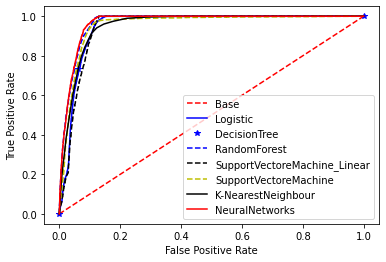

In [22]:
#area under curve
LG_auc = roc_auc_score(y_test, LG_probs)
print("AUC score: LG-", LG_auc)
DT_auc = roc_auc_score(y_test, DT_probs)
print("AUC score: DT-", DT_auc)
RF_auc = roc_auc_score(y_test, RF_probs)
print("AUC score: RF-", RF_auc)
SVM_linear_auc = roc_auc_score(y_test, SVM_probs_linear)
print("AUC score: SVM_linear-", SVM_linear_auc)
SVM_auc = roc_auc_score(y_test, SVM_probs)
print("AUC score: SVM-", SVM_auc)
KNN_auc = roc_auc_score(y_test, KNN_probs)
print("AUC score: KNN-", KNN_auc)
NN_auc = roc_auc_score(y_test, NN_y_pred)
print("AUC score: NN-", NN_auc)


#plot ROC curve
LG_fpr, LG_tpr, _ = roc_curve(y_test, LG_probs)
DT_fpr, Dt_tpr, _ = roc_curve(y_test, DT_probs)
RF_fpr, RF_tpr, _ = roc_curve(y_test, RF_probs)
SVM_fpr, SVM_tpr, _ = roc_curve(y_test, SVM_probs)
SVM_lin_fpr, SVM_lin_tpr, _ = roc_curve(y_test, SVM_probs_linear)
KNN_fpr, KNN_tpr, _ = roc_curve(y_test, KNN_probs)
NN_fpr, NN_tpr, _ = roc_curve(y_test, NN_y_pred)

plt.plot([0,1],[0,1],'r--', label='Base' )
# plot the roc curve for the model
plt.plot(LG_fpr, LG_tpr, 'b', label='Logistic')
plt.plot(DT_fpr, Dt_tpr, 'b*', label='DecisionTree')
plt.plot(RF_fpr, RF_tpr, 'b--', label='RandomForest')
plt.plot(SVM_lin_fpr, SVM_lin_tpr, 'k--', label='SupportVectoreMachine_Linear')
plt.plot(SVM_fpr, SVM_tpr, 'y--', label='SupportVectoreMachine')
plt.plot(KNN_fpr, KNN_tpr, 'k', label='K-NearestNeighbour')
plt.plot(NN_fpr, NN_tpr, 'r-', label='NeuralNetworks')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()
